In [1]:
!pip install tweet-preprocessor
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


### Acknowledgment
This kernel relies on fantastic kernels:

https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert

My goal was largely to replicate their work and reimplement it in pytorch

I also used code from the article:

https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

As well from Chris McCormick's excellent tutorial on using BERT:
https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=cRaZQ4XC7kLs

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
from torch.utils import data
from torch.backends import cudnn
import torch.optim as optim

import time
import preprocessor as tp
import re

import string
import pandas as pd
import numpy as np

from statistics import mean
from wordcloud import STOPWORDS
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
import time
import datetime


In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# EDA
Assumptions about the data to be tested:
1. There is an even split between disaster and non-disaster tweets - pie chart and bar chart
2. Count missing values

### Tasks:
1. Plot location frequency as descending order bar chart
2. Plot vertical axis plot, with keyword frequencies by target

### Meta features:
1. word count target_distribution in:
    a. training set
    b. training & test set
2. unique word count:
    a. training set
    b. training & test set
3. stop word count:
    a. training set
    b. training & test set
4. URL count:
    a. training set
    b. training & test set
5. mean word lenghts:
    a. training set
    b. training & test set
6. char count:
    a. training set
    b. training & test set
7. punctuation count
    a. training set
    b. training & test set
8. hashtag count    
    a. training set
    b. training & test set
9. mention count
    a. not disaster
    b. disaster
    
### n-grams anlysis
1. Countplot of the most frequent 1-, 2- and 3- grams for disaster and non-disaster tweets


## Load data

In [7]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


## Look into the data

In [8]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Count disaster vs non-disaster tweets

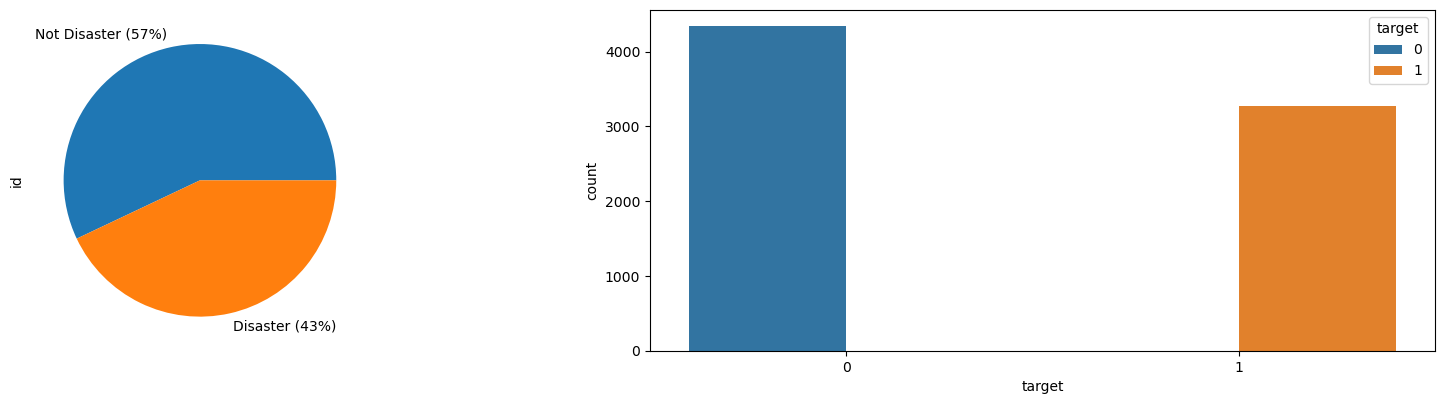

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1], )

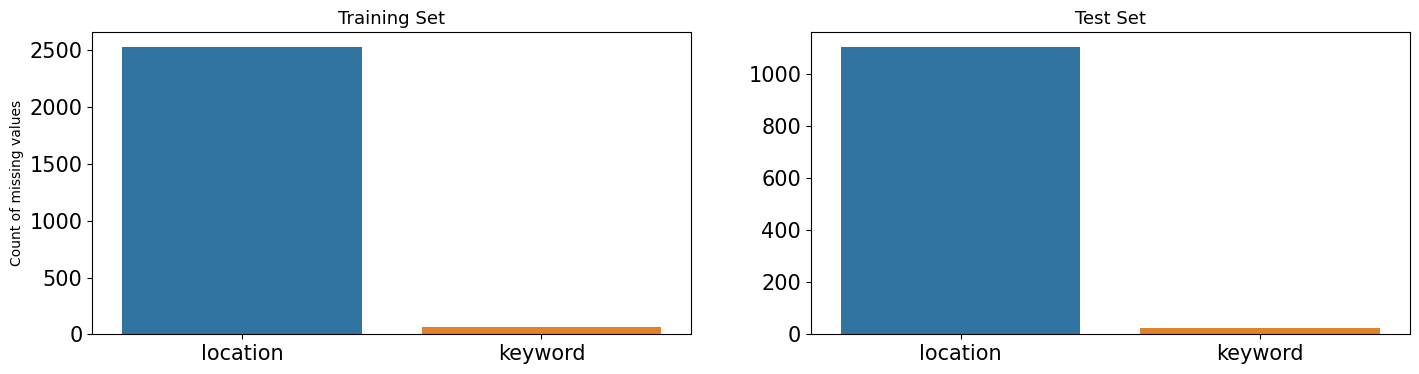

In [10]:
missing_columns = ["location", "keyword"]

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_columns].isnull().sum().index, y=df_train[missing_columns].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_columns].isnull().sum().index, y=df_test[missing_columns].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel("Count of missing values")
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)
plt.show()

# every null value should be replaced with no_x

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [11]:
df_train.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


## Cardinality and Target Distribution

In [12]:
df_train['keyword'].value_counts().size

222

In [13]:
df_train.groupby('keyword')['keyword'].nunique()

keyword
ablaze                 1
accident               1
aftershock             1
airplane%20accident    1
ambulance              1
                      ..
wounded                1
wounds                 1
wreck                  1
wreckage               1
wrecked                1
Name: keyword, Length: 222, dtype: int64

In [14]:
print(f"Number of unique values in keywords: training - {df_train['keyword'].value_counts().size}, test {df_test['keyword'].value_counts().size}")
print(f"Number of unique values in location: training - {df_train['location'].value_counts().size}, test {df_test['location'].value_counts().size}")

Number of unique values in keywords: training - 222, test 222
Number of unique values in location: training - 3342, test 1603


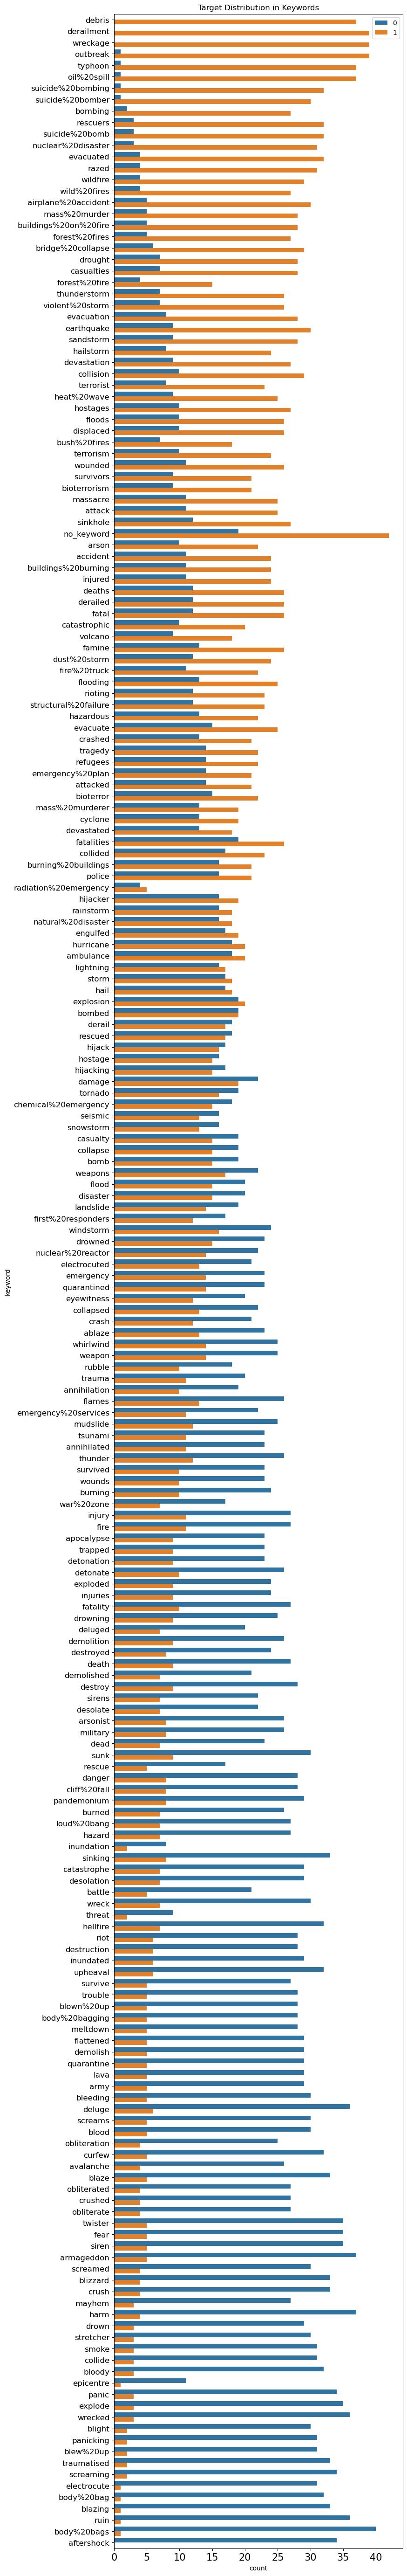

In [15]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

## Meta features
* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` of urls in text
* `mean_word_length` average character count in words
* `char_count` of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` of hashtags (#) in text
* `mention_count` number of mentions (@) in text


In [16]:
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))
                                                       
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if "http" in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if "http" in w]))

df_train['mean_word_length'] = df_train['text'].apply(lambda x: mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: mean([len(w) for w in str(x).split()]))

df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

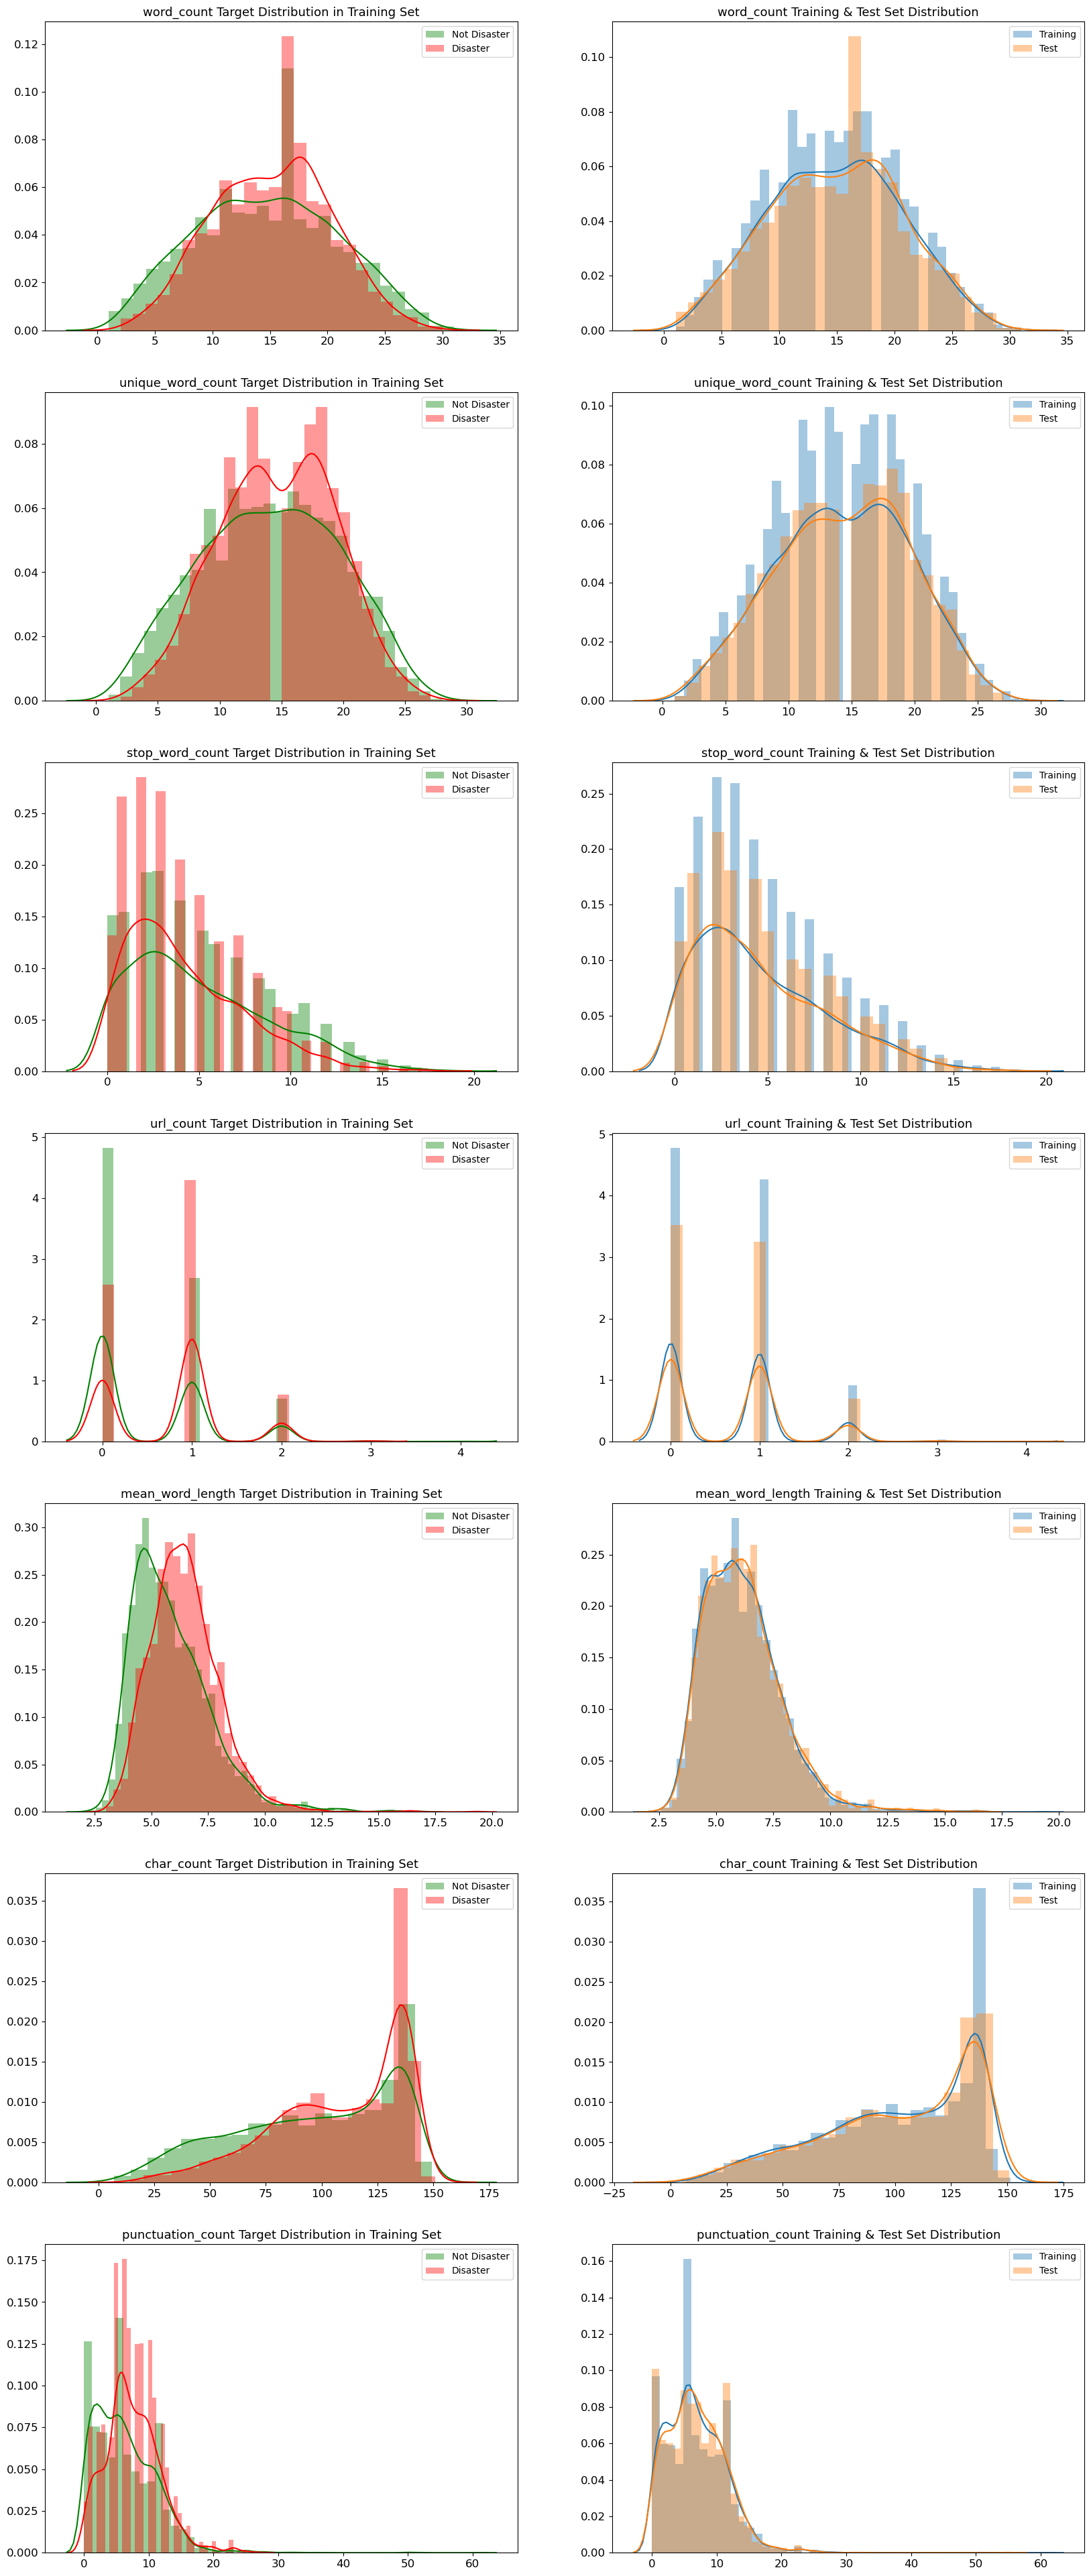

In [17]:
meta_features = ["word_count", "unique_word_count", "stop_word_count", "url_count", "mean_word_length", "char_count", "punctuation_count"]

DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2,
                      nrows=len(meta_features),
                      figsize=(20,50),
                      dpi=100)

for (i, feature) in enumerate(meta_features):    
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label="Not Disaster", ax=axes[i][0], color="green")
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label="Disaster", ax=axes[i][0], color="red")
    
    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

### Preprocessing tweets

In [18]:
# remove URLs, emojis, mentions, smileys and numbers
tp.set_options(tp.OPT.URL,
               tp.OPT.EMOJI,
               tp.OPT.MENTION,
               tp.OPT.SMILEY,
               tp.OPT.NUMBER)

In [19]:
# apply preprocessing
df_train['preprocessed_text'] = df_train['text'].apply(lambda x: tp.clean(x))
df_test['preprocessed_text'] = df_test['text'].apply(lambda x: tp.clean(x))

### replace hashtags with words

In [20]:
df_train['preprocessed_text'] = df_train['preprocessed_text'].apply(lambda x: re.sub(r"#(\w+)", r"\1", x))
df_test['preprocessed_text'] = df_test['preprocessed_text'].apply(lambda x: re.sub(r"#(\w+)", r"\1", x))

### Tokenization process
1. Create the BertTokenizer object
2. Count tokens
3. SNS plot
4. Tokenize dataframes & add attention masks


In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [22]:
df_train['token_count'] = df_train['preprocessed_text'].apply(lambda x: len(tokenizer.encode(x)))
df_test['token_count'] = df_test['preprocessed_text'].apply(lambda x: len(tokenizer.encode(x)))

## Token numbers countplot

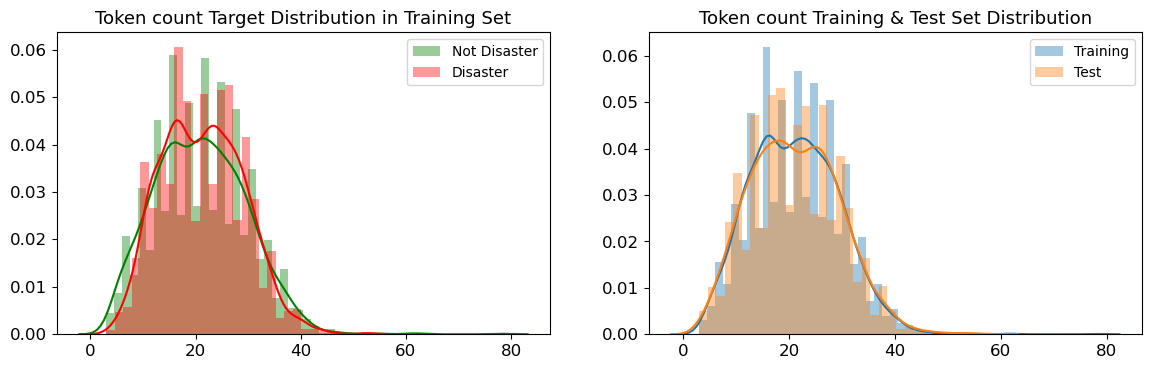

In [23]:
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2,
                      nrows=1,
                      figsize=(14,4),
                        dpi=100)

sns.distplot(df_train.loc[~DISASTER_TWEETS]["token_count"], label="Not Disaster", ax=axes[0], color="green")
sns.distplot(df_train.loc[DISASTER_TWEETS]["token_count"], label="Disaster", ax=axes[0], color="red")

sns.distplot(df_train["token_count"], label='Training', ax=axes[1])
sns.distplot(df_test["token_count"], label='Test', ax=axes[1])
    
for j in range(2):
    axes[j].set_xlabel('')
    axes[j].tick_params(axis='x', labelsize=12)
    axes[j].tick_params(axis='y', labelsize=12)
    axes[j].legend()
    
axes[0].set_title(f'Token count Target Distribution in Training Set', fontsize=13)
axes[1].set_title(f'Token count Training & Test Set Distribution', fontsize=13)

plt.show()

In [24]:
print(f"Max token count is {max(df_train['token_count'].max(), df_test['token_count'].max())}")

Max token count is 78


In [25]:
# method for tokenizing data from dataframes
def tokenize_dataframe(df, include_labels = True):
    input_ids = []
    attention_masks = []
    
    # For every tweet
    for tweet in df["preprocessed_text"]:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 128,           # Pad & truncate all sentences to 128 - max tokens is 78
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if include_labels:
        labels = torch.tensor(df.target.values).long()
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

## Address class inbalance - use Weighted Sampler
Normally, we would be alright using just SequentialSampler. However, in this case classes are unbalanced and WeightedSampler is needed.

In [26]:
def get_weighted_sampler_for_subset(subset):
    ds = subset.dataset[subset.indices]
    labels = ds[2].numpy()
    unique_labels, class_counts = np.unique(labels, return_counts = True)
    num_samples = sum(class_counts)

    print(f"Non-disaster vs Disaster: {class_counts[0]} / {class_counts[1]}")

    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[labels[i]] for i in range(int(num_samples))]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    return sampler

## Generate the datasets

In [27]:
# Use BERT Tokenizer on train and test data
ds_inputs, ds_attentions_masks, ds_labels = tokenize_dataframe(df_train, include_labels = True)
test_inputs, test_attention_masks = tokenize_dataframe(df_test, include_labels = False)

# Generate TensorDatasets
dataset = TensorDataset(ds_inputs, ds_attentions_masks, ds_labels)
test_dataset = TensorDataset(test_inputs, test_attention_masks)

# Create a 80-20 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# # Divide the dataset by randomly selecting samples.
train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])

print(f"{train_size} training samples")
print(f"{val_size} validation samples")

6090 training samples
1523 validation samples


### Create samplers and data loaders

In [28]:
batch_size = 32

# Create the DataLoader for training data
train_sampler = get_weighted_sampler_for_subset(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for validation data
validation_sampler = get_weighted_sampler_for_subset(validation_dataset)
validation_dataloader = DataLoader(validation_dataset, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for test data
test_dataset = TensorDataset(test_inputs, test_attention_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

Non-disaster vs Disaster: 3465 / 2625
Non-disaster vs Disaster: 877 / 646


## Create the model object

In [29]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [30]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [31]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [32]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [33]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [34]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:16.
  Batch    80  of    191.    Elapsed: 0:00:32.
  Batch   120  of    191.    Elapsed: 0:00:48.
  Batch   160  of    191.    Elapsed: 0:01:03.

  Average training loss: 0.44
  Training epcoh took: 0:01:15

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.40
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:15.
  Batch    80  of    191.    Elapsed: 0:00:31.
  Batch   120  of    191.    Elapsed: 0:00:47.
  Batch   160  of    191.    Elapsed: 0:01:02.

  Average training loss: 0.31
  Training epcoh took: 0:01:14

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.48
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    191.    Elapsed: 0:00:16.
  Batch    80  of    191.    Elapsed: 0:00:31.
  Batch   120  of    191.    Elapsed: 0:00:47.
  Batch   160  of    191.    Elapsed: 0:01:02.



In [35]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.44,0.40,0.82,0:01:15,0:00:06
2,0.31,0.48,0.80,0:01:14,0:00:06
3,0.26,0.51,0.80,0:01:14,0:00:06
4,0.22,0.50,0.82,0:01:14,0:00:06


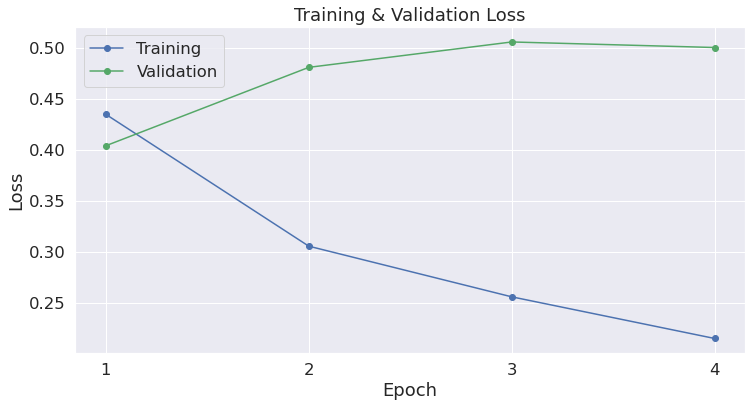

In [36]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Predictions on test dataset

In [37]:
# Prediction on test set

print(f'Predicting labels for {len(test_dataset)} test sentences...')

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Store predictions and true labels
    for logit in logits:
        predictions.append(logit)

print('    DONE.')

Predicting labels for 3263 test sentences...
    DONE.


### Reformat logits into actual predictions

In [38]:
predictions_class = []
ids = []

for i in range(len(predictions)):
    predictions_class.append(np.argmax(predictions[i]))
    ids.append(df_test["id"][i])

In [39]:
my_submission = pd.DataFrame({"Id" : ids, "target" : predictions_class})

In [40]:
# export to csv
my_submission.to_csv("my_submission.csv", index=False)